2.1 Gán nhãn ảnh

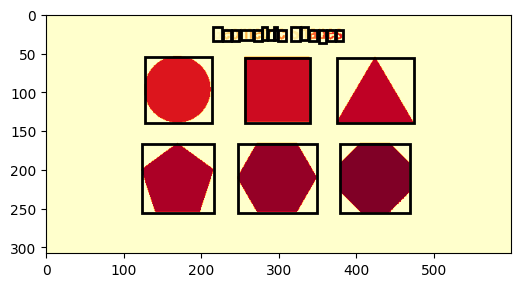

In [2]:
from PIL import Image
import numpy as np
import imageio.v2 as iio
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters import threshold_otsu

data = Image.open('geometric.png').convert('L')
a = np.asarray(data)

thres = threshold_otsu(a)
b = a > thres

c = label(b)

# ✅ Sửa lỗi khi lưu ảnh: chuyển về uint8 trước khi lưu
iio.imsave('label_output.jpg', (c.astype(np.uint8) * 30))

d = regionprops(c)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(c, cmap='YlOrRd')

for i in d:
    lr, lc, ur, uc = i['BoundingBox']
    rec_width = uc - lc
    rec_height = ur - lr
    rect = mpatches.Rectangle((lc, lr), rec_width, rec_height, fill=False,
                              edgecolor='black', linewidth=2)
    ax.add_patch(rect)

plt.show()


2.3 Dò tìm cạnh Sober Filter

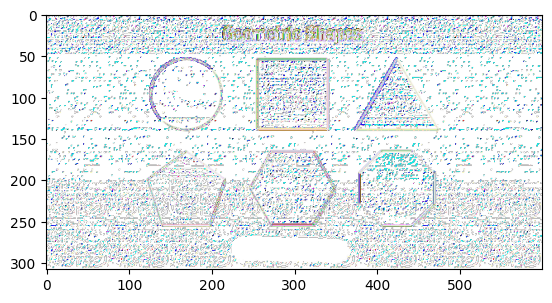

In [3]:
from PIL import Image
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

data = Image.open('geometric.png')
a = nd.sobel(data, axis=0)
b = nd.sobel(data, axis=1)
bmg = abs(a) + abs(b)

plt.imshow(bmg)
plt.show()


2.4 Xác định góc đối tượng

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-49.800000000000004..255.0].


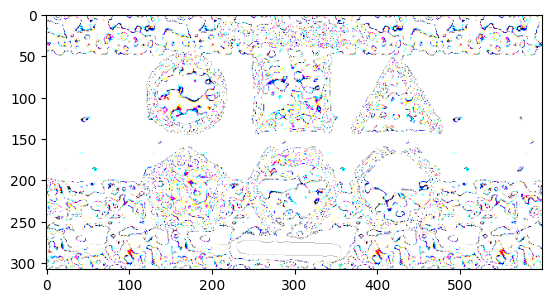

In [1]:
from PIL import Image
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

def Harris(indata, alpha=0.2):
    x = nd.sobel(indata, 0)
    y = nd.sobel(indata, 1)
    xl = x ** 2
    yl = y ** 2
    xy = abs(x * y)
    xl = nd.gaussian_filter(xl, 3)
    yl = nd.gaussian_filter(yl, 3)
    xy = nd.gaussian_filter(xy, 3)

    detC = xl * yl - 2 * xy
    trC = xl + yl
    R = detC - alpha * trC**2
    return R

data = Image.open('geometric.png')
bmg = Harris(data)
plt.imshow(bmg)
plt.show()


2.5 Do tim hinh dang cu the

2.5.1 Do tim duong thang trong anh


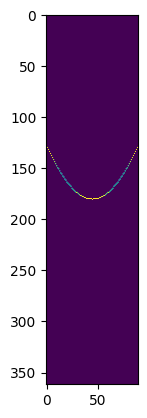

In [2]:
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

def LineHough(data, gamma):
    V, H = data.shape
    R = int(np.sqrt(V * V + H * H))
    ho = np.zeros((R, 90), float)  # Hough space
    w = data + 0
    ok = 1
    theta = np.arange(90) / 180.0 * np.pi
    tp = np.arange(90).astype(float)
    while ok:
        mx = w.max()
        if mx < gamma:
            ok = 0
        else:
            v, h = divmod(w.argmax(), H)
            y = V - v
            x = h
            rh = x * np.cos(theta) + y * np.sin(theta)
            for i in range(len(rh)):
                if 0 <= rh[i] < R and 0 <= tp[i] < 90:
                    ho[int(rh[i]), int(tp[i])] += mx
            w[v, h] = 0
    return ho

data = np.zeros((256, 256))
data[128, 128] = 1
bmg = LineHough(data, 0.5)
plt.imshow(bmg)
plt.show()


2.5.2 Do tim duong tron trong anh

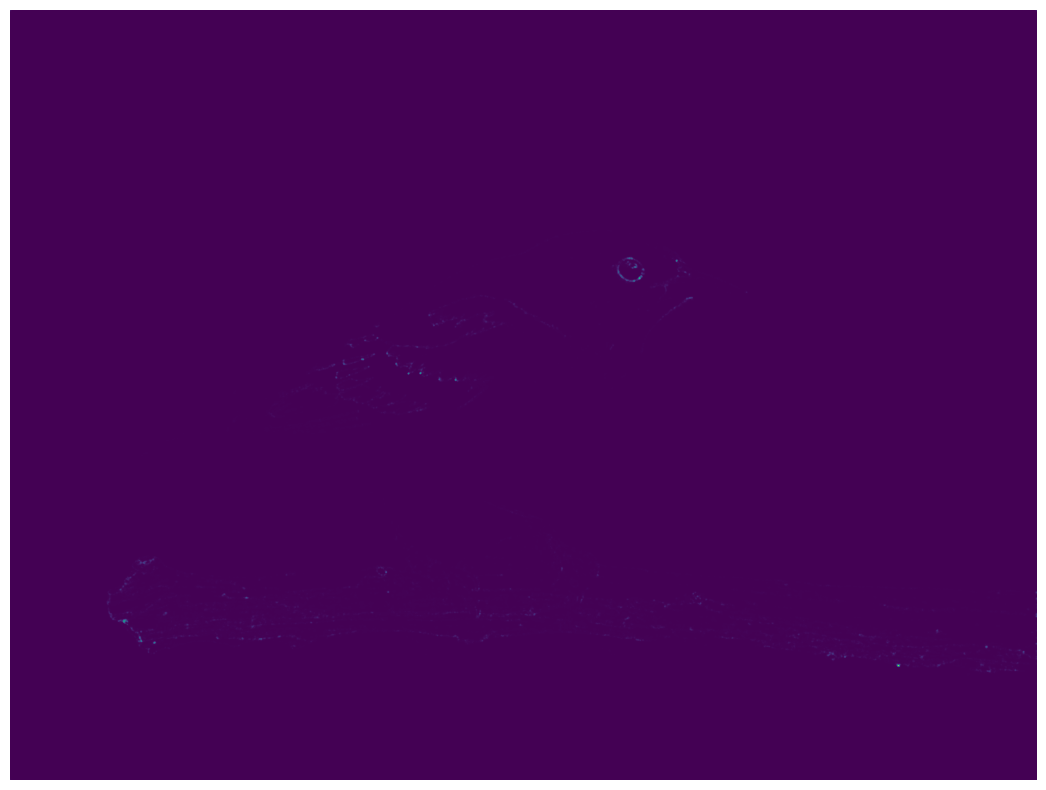

In [3]:
from PIL import Image
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.feature import corner_harris
from skimage.color import rgb2gray

data = iio.imread('bird.png')
image_gray = rgb2gray(data)
coordinate = corner_harris(image_gray, k = 0.001)

plt.figure(figsize=(20,10))
plt.imshow(coordinate)
plt.axis('off')
plt.show()


2.6

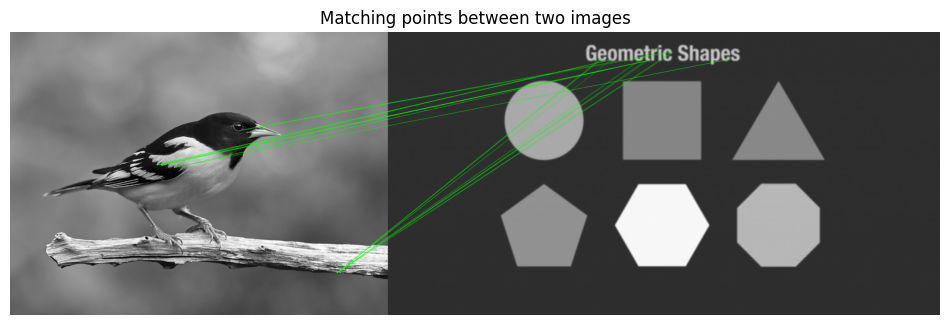

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# --- 1. Đọc ảnh xám ---
img1 = cv2.imread('bird.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('geometric.png', cv2.IMREAD_GRAYSCALE)

# --- 2. Phát hiện điểm góc bằng Harris ---
def detect_corners(img, max_points=200, block_size=2, ksize=3, k=0.04, threshold=0.01):
    dst = cv2.cornerHarris(img, block_size, ksize, k)
    dst = cv2.dilate(dst, None)
    corners = np.argwhere(dst > threshold * dst.max())  # [(y,x)]
    # Sắp xếp và lấy ra max_points điểm góc mạnh nhất
    values = dst[corners[:, 0], corners[:, 1]]
    sorted_idx = np.argsort(values)[::-1][:max_points]
    return corners[sorted_idx]

corners1 = detect_corners(img1)
corners2 = detect_corners(img2)

# --- 3. Trích xuất patch xung quanh mỗi điểm ---
def extract_patch(img, point, size=11):
    x, y = point[1], point[0]
    half = size // 2
    if y - half < 0 or y + half >= img.shape[0] or x - half < 0 or x + half >= img.shape[1]:
        return None
    return img[y-half:y+half+1, x-half:x+half+1]

# --- 4. So khớp bằng SSD ---
def match_corners(img1, img2, corners1, corners2, patch_size=11):
    matches = []
    for pt1 in corners1:
        patch1 = extract_patch(img1, pt1, patch_size)
        if patch1 is None:
            continue
        best_match = None
        min_ssd = float('inf')
        for pt2 in corners2:
            patch2 = extract_patch(img2, pt2, patch_size)
            if patch2 is None:
                continue
            ssd = np.sum((patch1.astype(np.float32) - patch2.astype(np.float32)) ** 2)
            if ssd < min_ssd:
                min_ssd = ssd
                best_match = pt2
        if best_match is not None:
            matches.append((pt1, best_match))
    return matches

# --- 5. Tìm điểm tương đồng ---
matches = match_corners(img1, img2, corners1, corners2)

# --- 6. Hiển thị kết quả ---
img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

# Resize img2 để khớp chiều cao với img1
if img1_color.shape[0] != img2_color.shape[0]:
    scale = img1_color.shape[0] / img2_color.shape[0]
    new_width = int(img2_color.shape[1] * scale)
    img2_color = cv2.resize(img2_color, (new_width, img1_color.shape[0]))

concat = np.hstack((img1_color, img2_color))

for pt1, pt2 in matches[:50]:  # Giới hạn 50 đường nối
    x1, y1 = pt1[1], pt1[0]
    # Tính lại tọa độ pt2 sau khi resize ảnh
    x2 = int(pt2[1] * scale) + img1.shape[1]
    y2 = int(pt2[0] * scale)
    cv2.line(concat, (x1, y1), (x2, y2), (0, 255, 0), 1)

plt.figure(figsize=(12, 6))
plt.imshow(concat[..., ::-1])
plt.title("diemtuongdong")
plt.axis("off")
plt.show()
